In [22]:
import os
from os.path import join as oj
import sys, time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import warnings
import skits
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

import statsmodels.tsa.api as smt
import traceback

font = {'size'   : 12}
plt.rc('font', **font)
cb = '#008fd5'
cr = '#fc4f30'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
x = np.arange(100)

In [32]:
p = 50


In [33]:
yhat = m.predict(xs)

*generate some arma data*

ar [ 0.79044204 -0.23140646] ma [0.70072895 0.40608016]


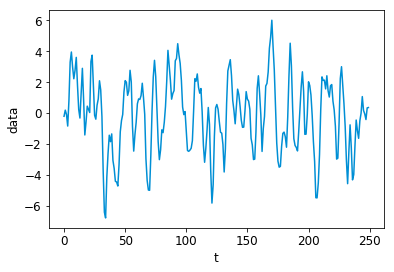

In [11]:
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

n = 250
sample = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, sigma=1)
p = 2
q = 2
mod = smt.ARMA(sample, order=(p, q)).fit(trend='nc', disp=0) #$=False) #, start_params=start_params, trend='nc')
print('ar', mod.params[:p], 'ma', mod.params[p:])
plt.plot(sample, color=cb)
plt.xlabel('t')
plt.ylabel('data')
plt.show()

In [ ]:
mod.summary()

*fit and inspect an individual model*

In [112]:
def pred_all(s, mod):
    '''Doesn't return first time-step, so preds are one shorter than sample size.
    Note - this updates mod.fittedvalues
    '''
    return mod.predict(exog=s) # this predicts in sample

def pred_next(s, mod):
    '''Predicts next value
    '''
    return mod.predict(start=0, end=s.size)[-1] # this predicts in sample

def fit(n=100, p=3, sigma=1, seed=1):    
    np.random.seed(seed)
    
    n = n + p
    
    
#     arparams = np.array([.75, -.25])
    arparams = np.array([0.75, -.25, 0.75, -.25, 0, 0, 0])    
    maparams = np.array([.65, .35])
    
    
#     arparams = np.random.randn(2)
#     maparams = np.random.randn(2)
    ar = np.r_[1, -arparams] # add zero-lag and negate
    ma = np.r_[1, maparams] # add zero-lag


    # start_params = [0] * (len(ar) + len(ma) + 3) # this is very strange
    sample = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n * 2 + 1, sigma=sigma)
    sample = smt.detrend(sample, order=1)
    sample_train = sample[:n]
    xs = np.vstack([sample_train[i: i + p] for i in range(0, sample_train.size - p)])
    ys = np.vstack([sample_train[i + p] for i in range(0, sample_train.size - p)])
    mod = LinearRegression().fit(xs, ys)
    preds_train = mod.predict(xs)
#     mod = smt.AR(sample_train).fit(maxlag=p) #, start_params=start_params, trend='nc')
#     mod = smt.AR(sample_train).fit(transparams=False, start_params=start_params, trend='nc')
#     mod = smt.ARMA(sample_train, order=(p, q)).fit(transparams=False, start_params=start_params, trend='nc')
    
    sample_test = sample[n:]
    xs = np.vstack([sample_test[i: i + p] for i in range(0, sample_test.size - p)])
    ys = np.vstack([sample_test[i + p] for i in range(0, sample_test.size - p)])
    mod = LinearRegression().fit(xs, ys)
    preds_test = mod.predict(xs)
    
    
#     print(n, xs.shape[0])
    '''
    plt.plot(sample_train[:preds_train.size])
    plt.plot(preds_train)
    plt.show()
#     preds_test = pred_next(sample_test, mod).reshape(1, 1)
    '''

    results = {
        'train_mse': metrics.mean_squared_error(sample_train[p:], preds_train), 
        'test_mse': metrics.mean_squared_error(sample_test[p:], preds_test), 
#         'aic': mod.aic,
#         'bic': mod.bic,
#         'llf': mod.llf,
#         'hqic': mod.hqic,
        'n': preds_train.size,
        'p': p,
        'sigma': sigma,
        'seed': seed
    }
    
    return results

# this n is before adding by p
ns = np.arange(5, 500, 3)
ps = [100]
sigma = 100
seeds = range(2)

results_list = []
for p in ps:
    for n in tqdm(ns):
        for seed in seeds:
            results_list.append(fit(n, p, sigma, seed))
df = pd.DataFrame(results_list, index=range(len(results_list)))
pkl.dump(df, open('df.pkl', 'wb'))

100%|██████████| 165/165 [00:05<00:00, 20.10it/s]


In [113]:
df.describe()

,n,p,seed,sigma,test_mse,train_mse
count,330.000000,330.0,330.000000,330.0,3.300000e+02,3.300000e+02
mean,251.000000,100.0,0.500000,100.0,5.003398e+03,5.211577e+03
std,143.108563,0.0,0.500759,0.0,2.925102e+03,3.131519e+03
min,5.000000,100.0,0.000000,100.0,2.961910e-27,3.554292e-27
25%,128.000000,100.0,0.000000,100.0,2.862274e+03,2.766895e+03
50%,251.000000,100.0,0.500000,100.0,6.341331e+03,6.547090e+03
75%,374.000000,100.0,1.000000,100.0,7.399804e+03,7.814443e+03
max,497.000000,100.0,1.000000,100.0,7.993662e+03,8.714206e+03


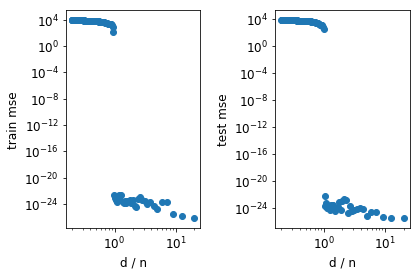

In [114]:
df = pkl.load(open('df.pkl', 'rb'))
df['num_train'] = df.n
# df['num_params'] = df.p + df.q
df['gamma'] = df.p / df.n
df = df.groupby(['n', 'p', 'sigma'])

# things that vary: n, p, q
r = df.mean()
# print(r.shape)
# plt.figure(dpi=200)
R, C = 1, 2
plt.subplot(R, C, 1)
plt.plot(r.gamma, r.train_mse.values, 'o')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('d / n')
plt.ylabel('Train MSE')

plt.subplot(R, C, 2)
plt.plot(r.gamma, r.test_mse.values, 'o')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('d / n')
plt.ylabel('Test MSE')
plt.tight_layout()

plt.show()

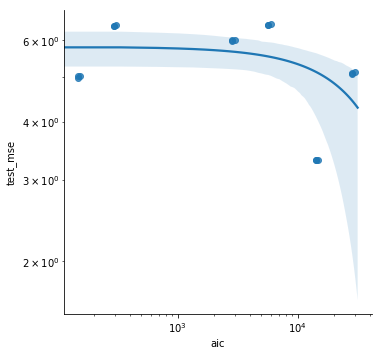

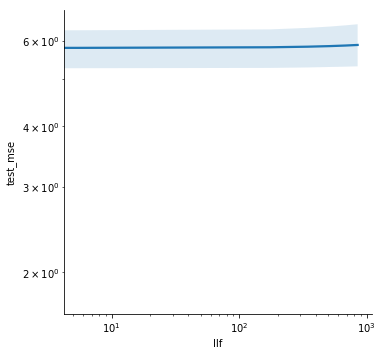

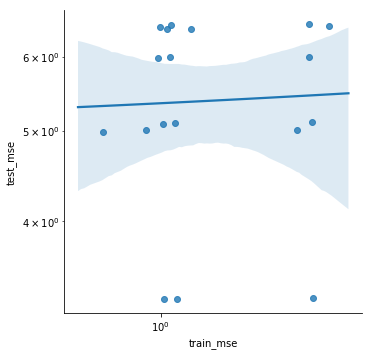

In [6]:
sns.lmplot('aic', 'test_mse', r)
plt.xscale('log')
plt.yscale('log')

sns.lmplot('llf', 'test_mse', r)
plt.xscale('log')
plt.yscale('log')

sns.lmplot('train_mse', 'test_mse', r)
plt.xscale('log')
plt.yscale('log')

In [ ]:
sns.pairplot(r[['train_mse', 'test_mse', 'bic', 'hqic', 'aic', 'llf']])

# analyze model selection

In [ ]:
# df_correct = pd.DataFrame.from_dict(correct_arr)
# results_all = {'df_correct': df_correct,
#                'sample_list': sample_list,
#                'results_list': results_list}
# pkl.dump(results_all, open('results_all.pkl', 'wb'))

In [5]:
results_all = pkl.load(open('results_all.pkl', 'rb'))

In [ ]:
results_all.keys()

In [ ]:
for i, r in enumerate(results_all['results_list']):
    print(i)
    for key in r:
        if 'min_order' in key:
            print('\t', key, r[key])

In [ ]:
# ar is row, max is col
results['bic']